# Stock Price Predictor using Deep and Machine Learning

##### Imports

In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.activations import linear, relu, sigmoid
import xgboost
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

## 1. Sequential Neural Network
I will predict the value of the next S&P candle using a Sequential Neural Network and historical data.

##### This cell is responsible for getting data about S&P500 market index from yfinance library and format it


In [4]:
### Importing data from yfinance, then deleting unnecessary columns
    
sp500 = yf.Ticker("^GSPC").history(start="1990-01-01")
del sp500["Dividends"]
del sp500["Stock Splits"]
del sp500["Volume"]

    ### Add predictors
    ### RSI and EMA are both indexes used in technical analysis of price charts.
    ### The calculation is performed using pandas technical analysis
    
sp500["RSI"] = ta.rsi(sp500["Close"], length = 14)
for timeframe in [5, 30, 60, 125, 250]:
    name = f"EMA_{timeframe}"
    sp500[name] = ta.ema(sp500["Close"], length=timeframe)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500["Change"] = (sp500["Tomorrow"] - sp500["Close"])/sp500["Close"] + 0.5

del sp500["Tomorrow"]
sp500 = sp500.dropna(subset=['EMA_250'])

    ### The actual value of the stock does not influence whether it goes up or down
    ### Transforms all values to coefficients relative to Open price for day
    
for name in ["High", "Low","Close", "RSI", "EMA_5", "EMA_30", "EMA_60", "EMA_125", "EMA_250"]:
    sp500[name] = (sp500[name] / sp500["Open"])
    
sp500["Open"] = (sp500["Open"] / sp500["Open"])
display(sp500.head(3))

    ### MinMaxScaller all scales data between 0 and 1, so that small differences become more noticable
    
sp500 = MinMaxScaler().fit_transform(sp500)

    ### Look back is a parameter that determines how many candles are used to predict the next one
    
look_back = 15

    ### Create a new list, where every line includes last {look_back} candles
    
    ### Results in 3D array
new_sp500 = []
for line in range(look_back, sp500.shape[0]+1):
    new_sp500.append(sp500[line-look_back:line, :-2])
    # This excludes first {look_back} candles, since we do not have full data about them
    
sp500 = sp500[look_back:]
new_sp500 = np.array(new_sp500)


    ### Split the data for training and testing
    
split = int(0.85*len(new_sp500))
X_train, X_test = new_sp500[:split, :], new_sp500[split:, :]
Y_train, Y_test = sp500[:split, -1:], sp500[split:, -1:]

# Check dimentions and formats
# print(X_train.shape)
# print(X_train)
# print(X_test.shape)
# print(X_test)
# print(Y_train.shape)
# print(Y_train)
# print(Y_test.shape)
# print(Y_test)

print("X_train.shape =", X_train.shape)
print("Y_train.shape =", Y_train.shape)
print("X_test.shape =", X_test.shape)
print("Y_test.shape =", Y_test.shape)

,Open,High,Low,Close,RSI,EMA_5,EMA_30,EMA_60,EMA_125,EMA_250,Target,Change
Date,,,,,,,,,,,,
1990-12-26 00:00:00-05:00,1.0,1.005456,1.000000,1.002910,0.186358,1.001281,0.983431,0.975463,0.984130,1.014577,0,0.492262
1990-12-27 00:00:00-05:00,1.0,1.000574,0.992081,0.992262,0.168690,0.996338,0.981331,0.973276,0.981449,1.011478,1,0.501310
1990-12-28 00:00:00-05:00,1.0,1.001310,0.996802,1.001310,0.172213,1.003175,0.989779,0.981536,0.989296,1.019222,1,0.504563


X_train.shape = (6990, 15, 10)
Y_train.shape = (6990, 1)
X_test.shape = (1234, 15, 10)
Y_test.shape = (1233, 1)


The data frame above resembles the one that is inputted as data into a neural network. The 'open' column only contains "1.0" because the data is scaled over its original value. This does not make a difference because we only need relative data (e.g., increase percentage).

## Building the model
A Sequential model consists of multiple layers. The input is a matrix with a shape of {look_back}x10, which derives from 10 coefficients for each candle we are analyzing. The Long Short-Term Memory (LSTM) layer is used because it excels at learning and recognizing long-term dependencies, which is essential for analyzing the sequence of candles.

In [5]:
    ### Commented layers are made to test when the neural network works the best
model = Sequential([
    tf.keras.Input(shape=(look_back,10)),
    #Dense(20, activation = linear, name = "L2"),
    #Dense(30, activation = tf.keras.activations.tanh, name = "L0"),
    LSTM(110, name = "L1"),
    #Dense(20, activation = linear, name = "L2"),
        ### The last layer consists of only one neuron because we require a single output.
    Dense(1, activation = linear, name = "L3"),
], name = "Sequential_model")

    ### Compile the model using the Adam optimizer and Mean Squared Error loss.
model.compile(loss='mse',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.summary()

Model: "Sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (LSTM)                   (None, 110)               53240     
                                                                 
 L3 (Dense)                  (None, 1)                 111       
                                                                 
Total params: 53,351
Trainable params: 53,351
Non-trainable params: 0
_________________________________________________________________


## Training the data
In this cell, we first train the model using X_train and Y_train, then make predictions on X_test, and finally plot the results to compare them with Y_test.

Epoch 1/5
1049/1049 [==============================] - 8s 4ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 2/5
1049/1049 [==============================] - 4s 4ms/step - loss: 0.0026 - val_loss: 9.9788e-04
Epoch 3/5
1049/1049 [==============================] - 4s 4ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 4/5
1049/1049 [==============================] - 4s 4ms/step - loss: 0.0025 - val_loss: 9.7086e-04
Epoch 5/5
39/39 [==============================] - 0s 2ms/step


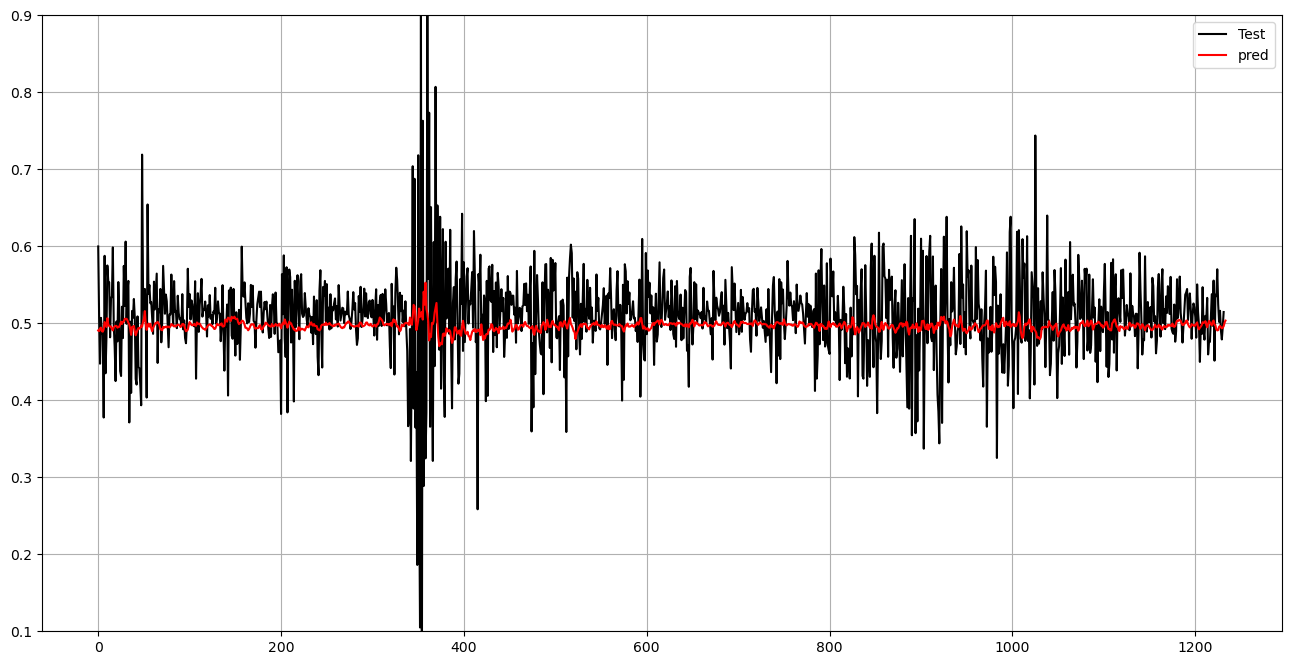

In [6]:
    ### Train the model
model.fit(
    X_train,
    Y_train,
    epochs=5,
    batch_size=6,
    validation_split = 0.1,
    shuffle=True
)

    ### Make a prediction and transform the dimension so that it can be plotted.
tmr_prediction = np.array([X_test[-1]])
y_pred = model.predict(X_test)
y_pred = np.squeeze(y_pred)

    ### Plot vs testing data
plt.figure(figsize=(16,8))
plt.plot(Y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.grid()
plt.ylim(0.1, 0.9)
plt.show()

Get a closer look at the graph:

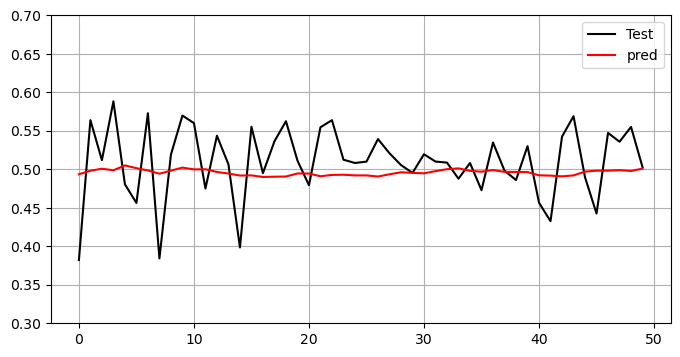

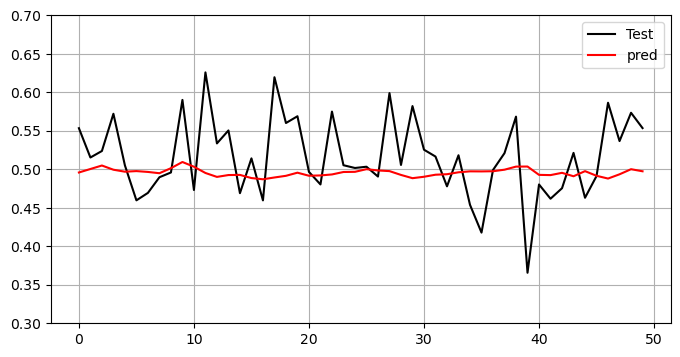

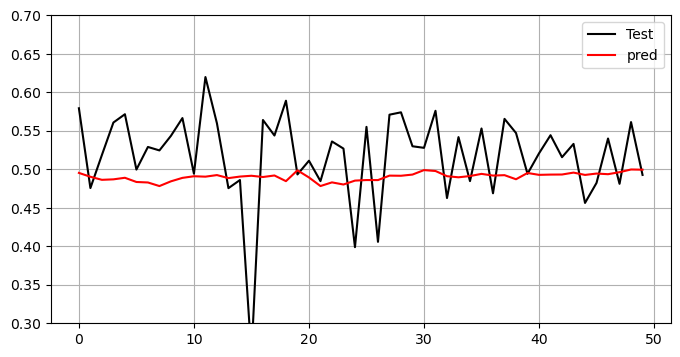

In [7]:
plt.figure(figsize=(8,4))
plt.plot(Y_test[200:250], color = 'black', label = 'Test')
plt.plot(y_pred[200:250], color = 'red', label = 'pred')
plt.legend()
plt.ylim(0.3, 0.7)
plt.grid()
plt.show()


plt.figure(figsize=(8,4))
plt.plot(Y_test[-300:-250], color = 'black', label = 'Test')
plt.plot(y_pred[-300:-250], color = 'red', label = 'pred')
plt.legend()
plt.ylim(0.3, 0.7)
plt.grid()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(Y_test[400:450], color = 'black', label = 'Test')
plt.plot(y_pred[400:450], color = 'red', label = 'pred')
plt.legend()
plt.ylim(0.3, 0.7)
plt.grid()
plt.show()

## Result analysis: 
&emsp;The Sequential neural network using LSTM made decent predictions for the S&P500 index. The results vary drastically with slight differences in parameters such as look_back, batch_size, and, of course, the number of neurons and layers. One of the most interesting insights was discovered regarding the training data window:
-  If the neural network is trained on all data after 1990, the overall trend is that the index went up. Consequently, the predictions mostly lie above the y=0.5 line.
-  However, if the training data starts from 2000, the average prediction lies on or slightly below the y=0.5 line.  


&emsp;Data engineering plays a vital role in building accurate predictions. Before using MinMaxScaler, the predictions were far from y=0.5, sometimes even reaching negative numbers. However, it's essential to ensure that the model is isolated from data leaks. Previous models were trained using leaked data and performed exceptionally well but were not applicable in real-life scenarios for future predictions.

## 2. Random Forest model

Random Forest models will be used for binary classification, determining whether the price goes up (1) or down (0).

### Input
This cell will retrieve data from yfinance and use ratios for the last 1, 2, 5, 60, 250, and 500 trading days. The trend is calculated as a rolling sum for the corresponding periods of time.

In [8]:
#Data input from ufinance, S&P500 stock
sp500 = yf.Ticker("^GSPC").history(start="1990-01-01")

#Transform data and add new predictors to train random forest model

#Add features that are based on historical data from N days ago
history = [1,2,5,60,250,500]
features = []

del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Change"] = sp500["Close"] - sp500["Open"]
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

    ### Create columns for ratios and trends
for timeframe in history:
    rolling_average = sp500.rolling(timeframe).mean()
    ratio_name = f"Ratio_for_{timeframe}"
    sp500[ratio_name] = sp500["Close"]/rolling_average["Close"]
    
    trend_name = f"Trend_for_{timeframe}"
    sp500[trend_name] = sp500.shift(1).rolling(timeframe).sum()["Target"]
    
    features += [ratio_name, trend_name]
sp500 = sp500.dropna(subset = sp500.columns[sp500.columns != "Tomorrow"])
sp500


,Open,High,Low,Close,Volume,Tomorrow,Change,Target,Ratio_for_1,Trend_for_1,Ratio_for_2,Trend_for_2,Ratio_for_5,Trend_for_5,Ratio_for_60,Trend_for_60,Ratio_for_250,Trend_for_250,Ratio_for_500,Trend_for_500
Date,,,,,,,,,,,,,,,,,,,,
1991-12-23 00:00:00-05:00,387.049988,397.440002,386.959991,396.820007,228900000,399.329987,9.770020,1,1.0,1.0,1.012477,2.0,1.026648,3.0,1.029791,28.0,1.057722,121.0,1.118215,253.0
1991-12-24 00:00:00-05:00,396.820007,401.790009,396.820007,399.329987,162640000,404.839996,2.509979,1,1.0,1.0,1.003153,2.0,1.024349,4.0,1.035790,28.0,1.063611,121.0,1.125031,254.0
1991-12-26 00:00:00-05:00,399.329987,404.920013,399.309998,404.839996,149230000,406.459991,5.510010,1,1.0,1.0,1.006852,2.0,1.027226,4.0,1.049373,28.0,1.077431,121.0,1.140239,255.0
1991-12-27 00:00:00-05:00,404.839996,406.579987,404.589996,406.459991,157950000,415.140015,1.619995,1,1.0,1.0,1.001997,2.0,1.018957,5.0,1.052744,29.0,1.080821,122.0,1.144452,256.0
1991-12-30 00:00:00-05:00,406.489990,415.140015,406.489990,415.140015,245600000,417.089996,8.650024,1,1.0,1.0,1.010565,2.0,1.026258,5.0,1.073804,30.0,1.102809,123.0,1.168488,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01 00:00:00-04:00,4530.600098,4541.250000,4501.350098,4515.770020,3246260000,4496.830078,-14.830078,0,1.0,1.0,1.000899,1.0,1.004878,4.0,1.014321,33.0,1.105050,122.0,1.072895,242.0
2023-09-05 00:00:00-04:00,4510.060059,4514.290039,4496.009766,4496.830078,3526250000,4465.479980,-13.229980,0,1.0,0.0,0.997899,1.0,0.997843,3.0,1.009300,32.0,1.099782,122.0,1.068404,242.0
2023-09-06 00:00:00-04:00,4490.350098,4490.350098,4442.379883,4465.479980,3418850000,4451.140137,-24.870117,0,1.0,0.0,0.996502,0.0,0.992302,2.0,1.001639,31.0,1.091596,121.0,1.060969,242.0


## Function for automatization of prediction
the threshold of making positive prediction is 60%
#### Backtest function used for training with correct data window
Function that selects the window of data to train on.
250 trading days = 1 trading year
The fist 250 predictions are made on first 2500 lines of data, that is,
11th year is predicted using previous 10 years
Then 12th year is trained using 11 previous years, 13th year using 12 previous years, and so on....

In [9]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predicted = model.predict_proba(test[predictors])[:,1]
    ### threshold = 0.6
    predicted[predicted >= .5] = 1
    predicted[predicted < .5] = 0
    predicted = pd.Series(predicted, index = test.index, name = "Predictions")
    ret = pd.concat([test["Target"], predicted], axis =1)
    return ret

def backtest(data, model, predictors, start=2500, step = 250):
    predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        prediction = predict(train, test, predictors, model)
        predictions.append(prediction)
    return pd.concat(predictions)

## 2.1 Random Forest Classifier model

Building the Random Forest Classifier model

In [10]:
rfmodel = RandomForestClassifier(n_estimators=180, min_samples_split=45, random_state=1)

##### Predicting

In [11]:
#Create a table of predictions
predictions = backtest(sp500, rfmodel, features)

##### Analyzing output

In [12]:
predictions["Predictions"].value_counts()

Predictions
1.0    3667
0.0    1820
Name: count, dtype: int64

the numbers above represent number of times model predicted the price to go up(1), and the price go down(0)

In [13]:
precision_score(predictions["Target"], predictions["Predictions"])

0.551949822743387

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.

### Test different values for *n_estimators* and  *min_samples_split* to find the best one
This function iterates through different hyperparameters of the model in order to find the most precise configuration.

**It usually takes a couple of hours to find the best model.**

    For model without backtesting:
High score = 0.6440677966101694;
n_estimators = 42, min_samples_split = 44, decision threshold = 50%

    For models with backtesting:
High score = 0.567043618739903;
n_estimators = 280, min_samples_split = 110, decision threshold = 60%

High score = 0.5912087912087912;
n_estimators = 180; min_samples_split = 45, decision threshold = 60%

In [ ]:
import time
start = time.time()

high_score = 0
high_n = -1
high_min = -1

for z in [0.5, 0.55, 0.6]:
    for n in range(60, 300, 20):
        print("Checking n =", n)
        for mins in range(30, 150, 5):
            def predict(train, test, predictors, model):
                model.fit(train[predictors], train["Target"])
                predicted = model.predict_proba(test[predictors])[:,1]
                predicted[predicted >= z] = 1
                predicted[predicted < z] = 0
                predicted = pd.Series(predicted, index = test.index, name = "Predictions")
                ret = pd.concat([test["Target"], predicted], axis =1)
                return ret
            model = RandomForestClassifier(n_estimators=n, min_samples_split=mins, random_state=1)
            predictions = backtest(sp500, model, features)
            score = precision_score(predictions["Target"], predictions["Predictions"])
            if score > high_score:
                high_score = score
                high_n = n
                high_min = mins
print(f'High score = {high_score}\nn_estimators = {high_n}; min_samples_split = {high_min}; threshold = {z}%')

end = time.time()
print("\nTime in seconds since the start:", end - start)

## 2.2 Random Forest Regressor model

*The random forest regressor is a similar model to the previous classifier, since I used predict_proba() function(in order to implement decision threshold)*

In [17]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predicted = model.predict(test[predictors])
    predicted = pd.Series(predicted, index = test.index, name = "Predictions")
    ret = pd.concat([test["Target"], predicted], axis =1)
    return ret

rfrmodel = RandomForestRegressor(n_estimators=180, min_samples_split=45, random_state=1)
predictions = backtest(sp500, rfrmodel, features)

#prediction threshold is best at 60% for this model(found experimentally)
thresholded_prediction = (predictions["Predictions"] >= 0.6).astype(int)
score = precision_score(predictions["Target"], thresholded_prediction)
print(f"precision score for this model is {score}")

precision score for this model is 0.5764150943396227


## 2.3 XGBRegressor model
The XGBRegressor is a regression model based on gradient boosting

In [18]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predicted = model.predict(test[predictors])
    predicted = pd.Series(predicted, index = test.index, name = "Predictions")
    ret = pd.concat([test["Target"], predicted], axis =1)
    return ret

xgbrmodel = XGBClassifier(objective="reg:squarederror", learning_rate = 0.1, n_estimators=180)
xgbr_out = backtest(sp500, xgbrmodel, features)
xgbr_out

,Target,Predictions
Date,,
2001-11-20 00:00:00-05:00,0,1
2001-11-21 00:00:00-05:00,1,1
2001-11-23 00:00:00-05:00,1,0
2001-11-26 00:00:00-05:00,0,0
2001-11-27 00:00:00-05:00,0,1
...,...,...
2023-09-01 00:00:00-04:00,0,0
2023-09-05 00:00:00-04:00,0,0
2023-09-06 00:00:00-04:00,0,1


## Unoptimized output for the XGBRegressor model
I used the values I believed would fit this model to test its performance.

In [19]:
print(precision_score(xgbr_out["Target"], xgbr_out["Predictions"]))
print(xgbr_out["Predictions"].value_counts())

0.5514705882352942
Predictions
1    3264
0    2223
Name: count, dtype: int64


### Test various values for this model to achieve the most accurate results.
This function iterates through different hyperparameters of the model in order to find the most precise configuration.

**It usually takes a couple of hours to find the best model.**

The highest score was achieved with the following configuration:

High score = **0.6351351351351351**

n_estimators = 160; max_depth = 2; learning_rate = 0.01; objective function = reg:squaredlogerror

This objective function is designed to optimize the model's predictions in a way that minimizes the squared logarithmic error between predicted and actual target values

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    predicted = model.predict(test[predictors])
    predicted = pd.Series(predicted, index = test.index, name = "Predictions")
    ret = pd.concat([test["Target"], predicted], axis =1)
    return ret

high_score = 0
high_max_depth = -1
high_n_estimators = -1
high_learning_rate = -1
high_objective = ""

for md in range(2, 10, 2):
    high_score = 0
    high_max_depth = -1
    high_n_estimators = -1
    high_learning_rate = -1
    high_objective = ""
    for n in range(60, 201, 20):
        for lr in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
            for obj in ["reg:squarederror", "reg:squaredlogerror", "reg:logistic", "binary:logistic", "binary:hinge"]:
                model = XGBClassifier(objective=obj, learning_rate = lr, n_estimators=n, max_depth = md)
                predictions = backtest(sp500, model, features)
                score = precision_score(predictions["Target"], predictions["Predictions"])
                if score > high_score:
                    high_score = score
                    high_max_depth = md
                    high_n_estimators = n
                    high_learning_rate = lr
                    high_objective = obj
    print(f'High score = {high_score}\nn_estimators = {high_n_estimators}; max_depth = {high_max_depth}; learning_rate = {high_learning_rate}; high_objective = {high_objective}')

print(f'High score = {high_score}\nn_estimators = {high_n_estimators}; max_depth = {high_max_depth}; learning_rate = {high_learning_rate}; high_objective = {high_objective}')